# Extraction of Regesta data from PDF files as tables.

In [2]:
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## FUNCTIONS

### Preprocessing
Prepares the visualisation of the position of content and text.
The page content is extracted as dictionary/JSON (see <https://pymupdf.readthedocs.io/en/latest/app1.html#dict-or-json>) 

In [5]:
# takes the path to the PDF file and the specified page range
# returns the page content and a DataFrame with the bbox coordinates for all blocks and lines
def preprocessing(path, pages):
    doc = fitz.open(path)
    
    # prepare lists to store content
    contents = []
    positional_data = []
    
    # for each page in the given page range:
    for page_num in range(pages[0] - 1, min(pages[1], len(doc))):
        page = doc.load_page(page_num)
        
        # add the content dictionary and page number to the contents list
        content = page.get_text("dict")
        content['page'] = page_num
        contents.append(content)
        
        # for each block on a page:       
        for block in content.get("blocks", []):
            b_bbox = block['bbox']
            
            # categorise the bbox coordinates of the block based on whether it is on an a- (even) or b- (uneven) page.
            if page_num % 2 == 0:
                positional_data.append((*b_bbox, 'ba', page_num))
            else:
                positional_data.append((*b_bbox, 'bb', page_num))
            positional_data.append((*b_bbox, 'b', page_num))
            
            # for each line in a block:
            for line in block.get("lines", []):
                line_bbox = line['bbox']
#                line_text = ''.join(span['text'] for span in line.get("spans", []))
                line_text = ''
                i_count = 0
                r_count = 0
                
                for span in line.get('spans', []):
                    line_text += span['text']        
                    if ('Italic' or 'italic') in span['font']:
                        i_count += 1
                    else:
                        r_count += 1
                        
                line_ital = True if i_count > r_count else False
                
                # categorise the bbox coordinates of the line based on whether it is on an a- or b-page.
                line_type = 'la' if page_num % 2 == 0 else 'lb'
                
                x_center = (line_bbox[0] + line_bbox[2]) / 2
                y_center = (line_bbox[1] + line_bbox[3]) / 2
                
                positional_data.append((*line_bbox, x_center, y_center, line_type, page_num, line_text, line_ital))            
                positional_data.append((*line_bbox, x_center, y_center, 'l', page_num, line_text, line_ital))

    # create bbox DataFrame
    bbox_df = pd.DataFrame(positional_data, columns=['x0', 'y0', 'x1', 'y1', 'x_center', 'y_center', 'type', 'page', 'line', 'italic'])

    return contents, bbox_df

### Plot
Plots the coordinates of blocks or lines

In [7]:
# takes the DataFrame with the coordinates of each block and line per page
# shows three scatter plots 
def plot_coordinates(df):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # plot bbox upper left coordinates (x0, y0)
    axs[0].scatter(df['x0'], df['y0'], color='red')
    axs[0].set_title('upper left coordinates: (x0, y0) ')
    axs[0].set_xlabel('x0')
    axs[0].set_ylabel('y0')
    
    # plot bbox midpoints ((x0+x1)/2, (y0+y1)/2)
    axs[1].scatter((df['x0'] + df['x1']) / 2, (df['y0'] + df['y1']) / 2, color='green')
    axs[1].set_title('midpoints: ((x0+x1)/2, (y0+y1)/2)')
    axs[1].set_xlabel('(x0+x1)/2')
    axs[1].set_ylabel('(y0+y1)/2')
    
    # plot bbox lower right coordinates (x1, y1)
    axs[2].scatter(df['x1'], df['y1'], color='blue')
    axs[2].set_title('lower right coordinates: (x1, y1)')
    axs[2].set_xlabel('x1')
    axs[2].set_ylabel('y1')
    
    # invert y-axis to reproduce page layout
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_pagelines(page, bbox_df):
    # takes the previous (maybe already prefiltered) DataFrame
    # shows each block or line as box
    rect_df = bbox_df

    # activate one of the following lines to specify page or page range
    rect_df = bbox_df[bbox_df['page']==page]
    rect_df = rect_df[rect_df['type'] == 'l']
    #rect_df = bbox_df[(216 < bbox_df['page']) & (bbox_df['page'] < 230)]

    fig, ax = plt.subplots(figsize=(5,7))

    for index, row in rect_df.iterrows():
        rect = patches.Rectangle(
            (row.iloc[0], row.iloc[1]), # (x, y)
            row.iloc[2] - row.iloc[0],  # width
            row.iloc[3] - row.iloc[1],  # height
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.set_xlim(0, 600)
    ax.set_ylim(0, 800)

    ax.invert_yaxis()
    plt.show()

### Classify lines
Rule-based classification of individual lines; the page structure allows a hierarchical approach.

In [10]:
# takes the bbox coordinates of each line, information about the previous line, and the page region parameters
# returns a classification for the given line
def classify_line(l_data, parameter):
    
    # to improve readability, the coordinates and calculations are stored in variables
    x0, y0, x1, y1 = l_data['l_bbox']
    x_center = (x0 + x1) / 2
    y_center = (y0 + y1) / 2
    width = x1 - x0
    
    if y_center < parameter['header_border'] and parameter['left_pagenumber_border'] < x_center < parameter['right_pagenumber_border']:
        return 'header'
    elif x_center < parameter['left_pagenumber_border'] and (y_center < parameter['header_border'] or y_center > parameter['footer_border']):    # left standing page number
        return 'a-page'
    elif x_center > parameter['right_pagenumber_border'] and (y_center < parameter['header_border'] or y_center > parameter['footer_border']):   # right standing page number
        return 'b-page'
    elif y_center > parameter['footer_border']:
        return 'footer'
    elif width < parameter['number_width'] and l_data['previous_line_end'] == 0 and parameter['mid_strip_start'] < x_center < parameter['mid_strip_end']:
        return 'c-Regestennummer'
    elif ((x0 - l_data['previous_line_end'] > 40) or (abs(l_data['previous_line_y'][0] - y0) > 10)) and (parameter['date_strip_start'] < x_center < parameter['date_strip_end']):
        return 'date'
    else:
        return 'other'

### Extract data
Main function to extract data

In [12]:
# takes the page contents extracted by preprocessing() and the manually defined page region parameters
# returns a classification for each text part
def extract_data(content, parameter):
    
    # prepare lists to store text and category
    classified_text = []
    previous_category = None
    previous_text = []
    # prepare counters for occurences of italic and regular spans inside a block
    i_count = 0
    r_count = 0
    
    # for each block:
    for block in content.get("blocks", []):
#        print("Block")
        
        # prepare variables to check relation between lines inside a block
        previous_line_y = (0,0)
        previous_line_end = 0
        
        # for each line:
        for line in block.get("lines", []):
            # store position data of the current line and transfer the data stored for the previous line
            l_data = {
                'l_bbox': line['bbox'],
                'previous_line_y': previous_line_y,
                'previous_line_end': previous_line_end
            }
            
            # combine the text of all the spans of the line
            l_text = ''.join(span['text'] for span in line.get("spans", []))
            
            # count the italic and regular spans of the line
            for span in line.get('spans', []):
                if ('Italic' or 'italic') in span['font']:
                    i_count += 1
                else:
                    r_count += 1
                # deal with OCR-errors that distort bboxes
                if span['bbox'][2] > 490:
#                    print('   ', span['bbox'], '    ', span['text'])
                    x0, y0, x1, y1 = l_data['l_bbox']
                    x1 = span['bbox'][0]
                    l_data['l_bbox'] = (x0, y0, x1, y1)
            
            # classify the line
            category = classify_line(l_data, parameter)
            # activate to print this part of the process
#            print ("   ", category, l_text, "i: ", i_count, "r: ", r_count)

            if category:
                # if the current category is different from the previous one or the current line starts within the indented page area:
                if category != previous_category or ((parameter['indentation_start'] < l_data['l_bbox'][0] < parameter['indentation_end']) and previous_line_end == 0):
                    # either save the previous text as 'Regestentext' if it is mainly written in italics
                    if previous_category == 'other' and i_count > r_count:
#                        print("   ", previous_category, previous_text, "i: ", i_count, "r: ", r_count, l_data['l_bbox'][0])
                        classified_text.append({
                            'type': 'e-Regestentext',
                            'value': ' '.join(previous_text)
                        })
                    # or save the previous text with its corresponding category
                    elif previous_category != None:
#                        print("   ", previous_category, previous_text, "i:", i_count, "r:", r_count, "x0:", l_data['l_bbox'][0], "previous_line_end:", previous_line_end)
                        classified_text.append({
                            'type': previous_category,
                            'value': ' '.join(previous_text)
                        })
                        
                    # set the current text and category as new reference values
                    previous_category = category
                    previous_text = [l_text]
                    # reset the counters for italic and regular text
                    i_count = 0
                    r_count = 0
                    
                # if the current category is the same as the previous category, append the text to the previously saved text
                else:
#                    print("   ", previous_category, previous_text, "i: ", i_count, "r: ", r_count, l_data['l_bbox'][0])
                    previous_text.append(l_text)
            
            # set the current x- and y-position as new reference values
            previous_line_end = l_data['l_bbox'][2]
            previous_line_y = (l_data['l_bbox'][1], l_data['l_bbox'][3])
            
    # save the last stored text and its category
    if previous_category:
        classified_text.append({
            'type': previous_category,
            'value': ' '.join(previous_text)
        })

    return classified_text

## INPUT PDF-DATA

In [14]:
# input path to PDF and page range
#PUU_in_Frankreich_NF_4_Picardie_Markiert.pdf     (165, 405)
path = 'PUU_in_Frankreich_NF_2_Normandie_Markiert.pdf'
pages = (194, 205)
contents, bbox_df = preprocessing(path, pages)

## Explore an unknown pdf file

### Content Overview

In [17]:
# quick overview of central dimensions for a bbox (insert coordinates manually)
test_box = (262.7601013183594, 223.137451171875, 412.09759521484375, 234.211669921875)
print('width:  ', test_box[2]-test_box[0])
print('height: ', test_box[3]-test_box[1])
print('x-center: ', (test_box[0]+test_box[2]) / 2)
print('y-center: ', (test_box[1]+test_box[3]) / 2)


width:   149.33749389648438
height:  11.07421875
x-center:  337.42884826660156
y-center:  228.674560546875


In [18]:
# overview of page content, block by block
    # if necessary, specify which blocks should be extracted so that, for example, image files are not displayed
    # e.g. starting from the 2nd block:     .get('blocks', [])[1:]
    # or everything except the last block:  .get('blocks', [])[:-1]


#content = contents[0]
#for block in content.get("blocks", [])[1:-1]:
#        print(block)

In [19]:
for content in contents:
    if content['page'] == 193:
#    if 18 <= content['page'] <= 20:
        for block in content.get('blocks', []): 
#            if block['type'] == 0:
#                print(block)
            for line in block.get('lines', []):
                l_text = ''
                for span in line.get("spans", []):
#                    if span['bbox'][2] > 490:
#                        print('   ', span['bbox'], '    ', span['text'])
#                        x0, y0, x1, y1 = line['bbox']
#                        x1 = span['bbox'][0]
#                        line['bbox'] = (x0, y0, x1, y1)
                    l_text += span['text']
                print(line['bbox'], '    ', l_text)

(244.24000549316406, 140.0179901123047, 298.4317626953125, 148.47799682617188)      Nr. 102—103. 
(415.608154296875, 140.0179901123047, 431.59783935546875, 148.47799682617188)      195 
(547.7151489257812, 137.45999145507812, 598.8685302734375, 149.08999633789062)      zyxwvutsrq
(135.2801513671875, 158.33351135253906, 343.9006042480469, 169.38201904296875)      Chartular s. XIII p. 6 n. 9 Êvreux Arch. dé 
(341.76617431640625, 158.33351135253906, 433.8977355957031, 169.38201904296875)      p. de l'Eure, G 122 
(113.68020629882812, 170.81361389160156, 234.8934783935547, 181.86212158203125)      [C]. — Reg. J.-L. 10543. 
(134.80018615722656, 190.73353576660156, 312.89605712890625, 201.78204345703125)      Das Jahr ergibt sich aus J.-L. 10546. 
(135.28109741210938, 213.8897705078125, 431.974365234375, 225.05226135253906)      Adrianus episcopus seruus seruorum Dei. Dilecto filio Herberto 
(114.40017700195312, 226.369873046875, 432.41619873046875, 237.53236389160156)      Ebroicensis eccle

### Visualisation

In [21]:
bbox_df

,x0,y0,x1,y1,x_center,y_center,type,page,line,italic
0,88.000000,87.889954,506.560028,755.089966,bb,193.000000,None,NaN,None,None
1,88.000000,87.889954,506.560028,755.089966,b,193.000000,None,NaN,None,None
2,244.240005,137.459991,598.868530,149.089996,bb,193.000000,None,NaN,None,None
3,244.240005,137.459991,598.868530,149.089996,b,193.000000,None,NaN,None,None
4,244.240005,140.017990,298.431763,148.477997,271.335884,144.247993,lb,193.0,Nr. 102—103.,False
...,...,...,...,...,...,...,...,...,...,...
1421,186.038940,635.828491,227.929291,644.550964,206.984116,640.189728,l,204.0,a) fehlt C.,True
1422,243.160446,635.730957,305.532593,644.550964,274.346519,640.140961,la,204.0,bj autoritate C.,True
1423,243.160446,635.730957,305.532593,644.550964,274.346519,640.140961,l,204.0,bj autoritate C.,True
1424,91.000000,89.489929,504.279999,752.849976,ba,204.000000,None,NaN,None,None


### Plot lines of a page

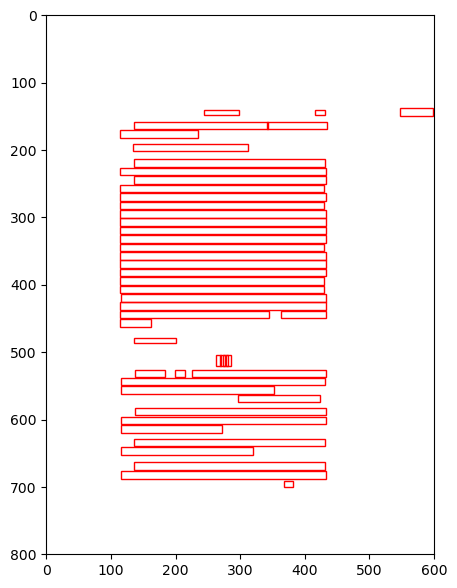

In [23]:
page = 193
plot_pagelines(page, bbox_df)

### Plot linepoints

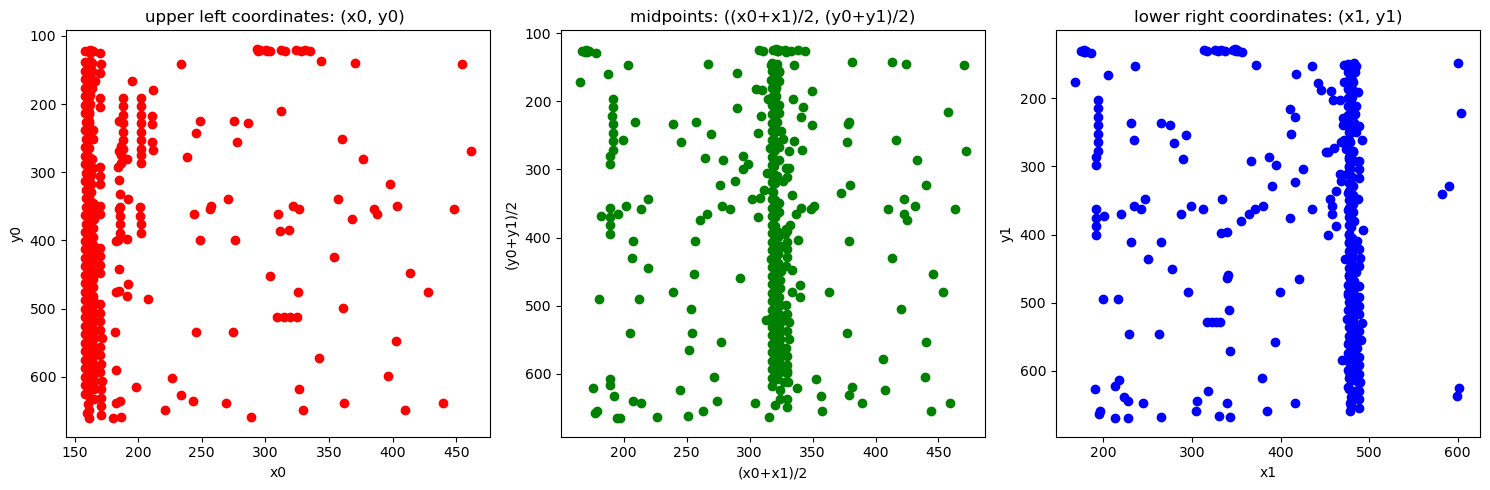

In [25]:
# adjust input to display: type == b for blocks, l for lines, ba or la and bb or lb for even and odd pages
vdf = bbox_df[bbox_df['type']=='la']
#vdf = vdf[vdf['page']==193]

# prepared filter options to view headers and footers more precisely. Activate one of the following lines to filter out or comment out everything in order to display the complete plot
#vdf = vdf[vdf['y1'] < 160]       # Header
#vdf = vdf[vdf['y1'] > 670]       # Footer
#vdf = vdf[vdf['x0'] < 170]       # indentation

#vdf = vdf[(vdf['page'] == 215)]  # single page
#vdf = vdf[(vdf['y1'] < 200) & (vdf['page'] == 215)]       # Header and page
#vdf = vdf[(vdf['y1'] > 600) & (vdf['page'] == 215)]       # Footer and page

plot_coordinates(vdf)

## SET PAGE REGION LIMITS
Use the plots to define boundaries for page regions on even (a) and odd (b) pages

In [27]:
# a = even page number
# b = odd page number

parameter_a = {
    'header_border' : 135,               # everything above
    'footer_border' : 800,               # everything below
    
    'left_pagenumber_border' : 200,      # everything left to (to exclude set to 0)
    'right_pagenumber_border' : 460,     # everything right to (to exclude set to a value greater than the page width)

    'indentation_start' : 128,           # everything between start and end
    'indentation_end' : 146,
    
    'mid_strip_start' : 300,             # everything between start and end
    'mid_strip_end' : 350,

    'date_strip_start' : 390,            # everything between start and end
    'date_strip_end' : 470,
    
    'number_width' : 30                  # maximal width of a regesta number
}

parameter_b = {
    'header_border' : 150,               # everything above
    'footer_border' : 800,               # everything below
    
    'left_pagenumber_border' : 0,        # everything left to (to exclude set to 0)
    'right_pagenumber_border' : 400,     # everything right to (to exclude set to a value greater than the page width)
    
    'indentation_start' : 165,           # everything between start and end
    'indentation_end' : 185,
    
    'mid_strip_start' : 250,             # everything between start and end
    'mid_strip_end' : 300,
    
    'date_strip_start' : 343,            # everything between start and end
    'date_strip_end' : 427,
    
    'number_width' : 30                  # maximal width of a regesta number
}

## MAIN - EXTRACT DATA

### Classify text

In [30]:
# takes the page contents extracted by preprocessing() and passes it together with the manually defined parameters depending on whether the page is even or odd
# returns the text parts and their classification
classified_texts = []

for content in contents:
    if (content['page'] % 2) == 0:
        classified_texts.append(extract_data(content, parameter_a))
    else:
        classified_texts.append(extract_data(content, parameter_b))
for text in classified_texts[0:2]:
    print(text)

[{'type': 'header', 'value': 'Nr. 102—103. '}, {'type': 'b-page', 'value': '195  zyxwvutsrq'}, {'type': 'other', 'value': 'Chartular s. XIII p. 6 n. 9 Êvreux Arch. dé  p. de l\'Eure, G 122  [C]. — Reg. J.-L. 10543.  Das Jahr ergibt sich aus J.-L. 10546.  Adrianus episcopus seruus seruorum Dei. Dilecto filio Herberto  Ebroicensis ecclesie sacriste salutem et apostolicam benedictionem.  Si rationabilibus filiorum nostrorum petitionibus grato assensu  concurrimus, officii nostri debitam exequimur actionem et ecclesia- sticis utilitatibus efficaciter prouidemus. Recepisti autem, dilecte in  domino fili Herber(te), a W. decano quandam domum cum perti- nenciis suis, que hactenus ad decanatum pertinuit, eamque, donec  de ipsa ecclesia fueris, tenere debebis, postea uero ad sacristiam  omni tempore pertinebit. Pro qua uidelicet domo uenerabilis frater  noster R. Ebroicensis episcopus et W. decanus aliam domum cum  pertinenciis suis, in qua idem decanus tune habitabat, omnibus de- canis post eu

### Sort text into regesta

In [32]:
# takes the classified text parts and assigns them to the corresponding Regestennummer
# returns the sorted regesta

# prepare variables 
regesta = []
current_regest = {}

# counter whose value can be added to a category to allow multiple entries of this category within the same Regest
k = 10

# for each regest:
for text in classified_texts:
    for item in text:
        
        # create a new dictionary, if the current item is classified as Regestennummer
        if item['type'] == "c-Regestennummer":
            if current_regest:
                regesta.append(current_regest)
            current_regest = {"c-Regestennummer": item['value']}
            k = 10
        # or append the current item to the current dictionary
        else:
            key = item['type']
            # directly or with a changed key (+k) to allow multiple entries of the current category within the same Regest
            if key in current_regest:
                key1 = key + f'{k}'
                current_regest[key1] = item['value']
                k += 1
            else:
                current_regest[item['type']] = item['value']
            
# add the last stored text and its category
if current_regest:
    regesta.append(current_regest)

for regest in regesta[0:2]:
    print(regest)

{'header': 'Nr. 102—103. ', 'b-page': '195  zyxwvutsrq', 'other': 'Chartular s. XIII p. 6 n. 9 Êvreux Arch. dé  p. de l\'Eure, G 122  [C]. — Reg. J.-L. 10543.  Das Jahr ergibt sich aus J.-L. 10546.  Adrianus episcopus seruus seruorum Dei. Dilecto filio Herberto  Ebroicensis ecclesie sacriste salutem et apostolicam benedictionem.  Si rationabilibus filiorum nostrorum petitionibus grato assensu  concurrimus, officii nostri debitam exequimur actionem et ecclesia- sticis utilitatibus efficaciter prouidemus. Recepisti autem, dilecte in  domino fili Herber(te), a W. decano quandam domum cum perti- nenciis suis, que hactenus ad decanatum pertinuit, eamque, donec  de ipsa ecclesia fueris, tenere debebis, postea uero ad sacristiam  omni tempore pertinebit. Pro qua uidelicet domo uenerabilis frater  noster R. Ebroicensis episcopus et W. decanus aliam domum cum  pertinenciis suis, in qua idem decanus tune habitabat, omnibus de- canis post eum in concambium") rationabili prouidentia capitulo  cons

### Postprocessing


In [34]:
# show regesta as table (DataFrame)
export_df = pd.DataFrame(regesta)
s_export_df = export_df.sort_index(axis=1)

s_export_df

,a-page,a-page16,b-page,b-page14,c-Regestennummer,date,date11,e-Regestentext,e-Regestentext10,header,header11,header13,header17,other,other10,other12,other15,other18
0,NaN,NaN,195 zyxwvutsrq,NaN,NaN,NaN,NaN,NaN,NaN,Nr. 102—103.,NaN,NaN,NaN,Chartular s. XIII p. 6 n. 9 Êvreux Arch. dé p...,NaN,NaN,NaN,NaN
1,196,NaN,NaN,NaN,1,Anagni 1160 Dezember 18.,13*,0 6 . Alexander III. nimmt das Domkapitel v...,Chartular s. XVI f. 58' Sées Bibl. de l'Evéché...,Nr. 163 — 165.,NaN,NaN,NaN,"quam futuris "" > regulärem uitam professis imp...",NaN,NaN,NaN,NaN
2,NaN,NaN,1 9 7,NaN,107.,(1162 März.),NaN,Der Legat Kardinalpriester Heinr(ich von SS. N...,NaN,Nr. 102—103.,NaN,NaN,NaN,"Chartular s. XIV f. 152' Paris Bibl. Nat., Ms....",Henr. Dei gratia sancte Romane ecclesie presbi...,NaN,NaN,NaN
3,198,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,Nr. 163 — 165.,NaN,NaN,NaN,0 8 . Der Legat Kardinalpriester Heinr(ich) ...,"predicto Rothomagensis archiepiscopi, habeas. ...",NaN,NaN,NaN
4,200,2 0 2,199,201,109. zyxwvutsrqponmlkjihgfedcbaZYXWVUTSRQPONML...,Tours 1162 November 9.,NaN,Alexander III. nimmt das Kloster Sainte-Trin...,NaN,Nr. 100.,Nr. 163 — 165.,Nr. 100.,ISrr. 109—110.,"Orig. Paris Ar ch. Nat., L 966 n. 10 [A] ; Cha...","de Basinuilla, ex dono Roberti de Caligneio te...",censis4-1 episcopi concessione fratrum duorum ...,"de Curua Fossa et quinque acras terre, ex dono...",pertinentiis | suis. Preterea de laboribuszyxw...
5,NaN,NaN,202 zyxwvutsrqponmlkjihgfedcbaZYXWV,NaN,1,Tours (1162) November 27.,NaN,1 0 . Alexander III. bestätigt dem Domkapit...,NaN,Nr. 102—103.,NaN,NaN,NaN,"Orig. London British Museum, Add. Charter 5414...","Die Urkunde Heinrichs 11. bei Delisle-Berger, ...",NaN,NaN,NaN
6,2 0 4,NaN,2 0 5,NaN,111.,Tours 1162 Dezember 10.,NaN,Alexander III. nimmt das Stift Saint-Nicolas...,NaN,Nr. 163 — 165.,Nr. 102—103.,NaN,NaN,"Kopie s. XVII Paris Bibl. Nat., Coli. Baluze ...","signorum appositio, et ipsam forestam ubique, ...","quartarium frumenti in molendino de Dodouilla,...",NaN,NaN
7,206,NaN,NaN,NaN,112.,Tours 1163 Januar 22.,NaN,Alexander III. nimmt die Kirche von Le Pless...,NaN,Nr. 163 — 165.,NaN,NaN,NaN,Chartular von 1493 Bd. I f. 5' Caen Arch. dép....,f Ego Henricus presb. card. tit. sanctorum Ner...,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,113.,Baris (1163) Februar 16.,NaN,Alexander III. bestätigt dem Domkapitel von ...,NaN,NaN,NaN,NaN,NaN,Chartular s. XIII f. 48 n. 175 Bayeux Bibl. du...,NaN,NaN,NaN,NaN


In [35]:
# group page numbers in one column
seite_columns = [col for col in s_export_df if 'page' in col]
s_export_df['Seitenbereich'] = s_export_df[seite_columns].astype(str).apply(lambda row: sorted(row.values), axis=1)
s_export_df.drop(columns=seite_columns, inplace=True)
s_export_df['Seitenbereich'] = s_export_df['Seitenbereich'].apply(lambda x: [i for i in x if i != 'nan'])
s_export_df

# group header in one column
header_columns = [col for col in s_export_df if 'header' in col]
s_export_df['Headerbereich'] = s_export_df[header_columns].astype(str).apply(lambda row: sorted(row.values), axis=1)
s_export_df.drop(columns=header_columns, inplace=True)
s_export_df['Headerbereich'] = s_export_df['Headerbereich'].apply(lambda x: [i for i in x if i != 'nan'])
s_export_df

,c-Regestennummer,date,date11,e-Regestentext,e-Regestentext10,other,other10,other12,other15,other18,Seitenbereich,Headerbereich
0,NaN,NaN,NaN,NaN,NaN,Chartular s. XIII p. 6 n. 9 Êvreux Arch. dé p...,NaN,NaN,NaN,NaN,[195 zyxwvutsrq],[Nr. 102—103. ]
1,1,Anagni 1160 Dezember 18.,13*,0 6 . Alexander III. nimmt das Domkapitel v...,Chartular s. XVI f. 58' Sées Bibl. de l'Evéché...,"quam futuris "" > regulärem uitam professis imp...",NaN,NaN,NaN,NaN,[196 ],[Nr. 163 — 165. ]
2,107.,(1162 März.),NaN,Der Legat Kardinalpriester Heinr(ich von SS. N...,NaN,"Chartular s. XIV f. 152' Paris Bibl. Nat., Ms....",Henr. Dei gratia sancte Romane ecclesie presbi...,NaN,NaN,NaN,[1 9 7 ],[Nr. 102—103. ]
3,1,NaN,NaN,NaN,NaN,0 8 . Der Legat Kardinalpriester Heinr(ich) ...,"predicto Rothomagensis archiepiscopi, habeas. ...",NaN,NaN,NaN,[198 ],[Nr. 163 — 165. ]
4,109. zyxwvutsrqponmlkjihgfedcbaZYXWVUTSRQPONML...,Tours 1162 November 9.,NaN,Alexander III. nimmt das Kloster Sainte-Trin...,NaN,"Orig. Paris Ar ch. Nat., L 966 n. 10 [A] ; Cha...","de Basinuilla, ex dono Roberti de Caligneio te...",censis4-1 episcopi concessione fratrum duorum ...,"de Curua Fossa et quinque acras terre, ex dono...",pertinentiis | suis. Preterea de laboribuszyxw...,"[199 , 2 0 2 , 200 , 201 ]","[ISrr. 109—110. , Nr. 163 — 165. , Nr. 100...."
5,1,Tours (1162) November 27.,NaN,1 0 . Alexander III. bestätigt dem Domkapit...,NaN,"Orig. London British Museum, Add. Charter 5414...","Die Urkunde Heinrichs 11. bei Delisle-Berger, ...",NaN,NaN,NaN,[202 zyxwvutsrqponmlkjihgfedcbaZYXWV],[Nr. 102—103. ]
6,111.,Tours 1162 Dezember 10.,NaN,Alexander III. nimmt das Stift Saint-Nicolas...,NaN,"Kopie s. XVII Paris Bibl. Nat., Coli. Baluze ...","signorum appositio, et ipsam forestam ubique, ...","quartarium frumenti in molendino de Dodouilla,...",NaN,NaN,"[2 0 4 , 2 0 5 ]","[Nr. 163 — 165. , Nr. 102—103. ]"
7,112.,Tours 1163 Januar 22.,NaN,Alexander III. nimmt die Kirche von Le Pless...,NaN,Chartular von 1493 Bd. I f. 5' Caen Arch. dép....,f Ego Henricus presb. card. tit. sanctorum Ner...,NaN,NaN,NaN,[206 ],[Nr. 163 — 165. ]
8,113.,Baris (1163) Februar 16.,NaN,Alexander III. bestätigt dem Domkapitel von ...,NaN,Chartular s. XIII f. 48 n. 175 Bayeux Bibl. du...,NaN,NaN,NaN,NaN,[],[]


## EXPORT AS CSV

In [37]:
# show path and page range of the input to manually adjust the name of the output file
print(path, '   ', pages)

PUU_in_Frankreich_NF_2_Normandie_Markiert.pdf     (194, 205)


In [38]:
exportname = path.replace('.pdf', '')
exportpath = f'{exportname}_{pages[0]}-{pages[1]}.csv'
s_export_df.to_csv(exportpath, index=True)
print(exportpath)

PUU_in_Frankreich_NF_2_Normandie_Markiert_194-205.csv


### Show parameter

In [40]:
print ("#parameter_a =", parameter_a)
print ("#parameter_b =", parameter_b)

#parameter_a = {'header_border': 135, 'footer_border': 800, 'left_pagenumber_border': 200, 'right_pagenumber_border': 460, 'indentation_start': 128, 'indentation_end': 146, 'mid_strip_start': 300, 'mid_strip_end': 350, 'date_strip_start': 390, 'date_strip_end': 470, 'number_width': 30}
#parameter_b = {'header_border': 150, 'footer_border': 800, 'left_pagenumber_border': 0, 'right_pagenumber_border': 400, 'indentation_start': 165, 'indentation_end': 185, 'mid_strip_start': 250, 'mid_strip_end': 300, 'date_strip_start': 343, 'date_strip_end': 427, 'number_width': 30}
